# The Truth About Injection Geometry

## Critical Finding: The Length Confound

**Previous claim:** Injection prompts have a distinct "geometric signature" - more features, lower concentration, weaker connections.

**Reality:** This signature is largely a **length artifact**.

| Finding | Original Analysis | Length-Controlled |
|---------|-------------------|-------------------|
| n_active | d=1.1, p<0.001*** | d=0.5, p=0.12 |
| concentration | d=1.2, p<0.001*** | d=0.3, p=0.45 |
| mean_influence | d=1.3, p<0.001*** | d=0.3, p=0.16 |

---

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
import warnings
warnings.filterwarnings('ignore')

random.seed(42)
np.random.seed(42)

with open('../data/results/pint_attribution_metrics.json') as f:
    data = json.load(f)

samples = data['samples']
injections = [s for s in samples if s['label']]
benigns = [s for s in samples if not s['label']]

print(f"Dataset: {len(samples)} samples")
print(f"Injection: {len(injections)} | Benign: {len(benigns)}")

Dataset: 136 samples
Injection: 21 | Benign: 115


## The Confound: Length → Everything

**Key insight:** Prompt length correlates almost perfectly (r=0.96) with number of active features.

In [2]:
# Length statistics
inj_lens = [len(s['text']) for s in injections]
ben_lens = [len(s['text']) for s in benigns]

print("LENGTH STATISTICS")
print("=" * 50)
print(f"Injection: {np.mean(inj_lens):.0f} ± {np.std(inj_lens):.0f} chars")
print(f"Benign: {np.mean(ben_lens):.0f} ± {np.std(ben_lens):.0f} chars")
print(f"Difference: {100*(np.mean(inj_lens)/np.mean(ben_lens) - 1):.0f}% longer")
print()

# Correlation with metrics
all_lens = [len(s['text']) for s in samples]
print("CORRELATIONS WITH LENGTH")
print("-" * 50)
for metric in ['n_active', 'n_edges', 'top_100_concentration', 'mean_influence']:
    vals = [s.get(metric, 0) for s in samples]
    r, p = stats.pearsonr(all_lens, vals)
    print(f"{metric:<25} r={r:+.3f} (p={p:.4f})")

LENGTH STATISTICS
Injection: 108 ± 50 chars
Benign: 62 ± 49 chars
Difference: 75% longer

CORRELATIONS WITH LENGTH
--------------------------------------------------
n_active                  r=+0.963 (p=0.0000)
n_edges                   r=+0.918 (p=0.0000)
top_100_concentration     r=-0.735 (p=0.0000)
mean_influence            r=-0.830 (p=0.0000)


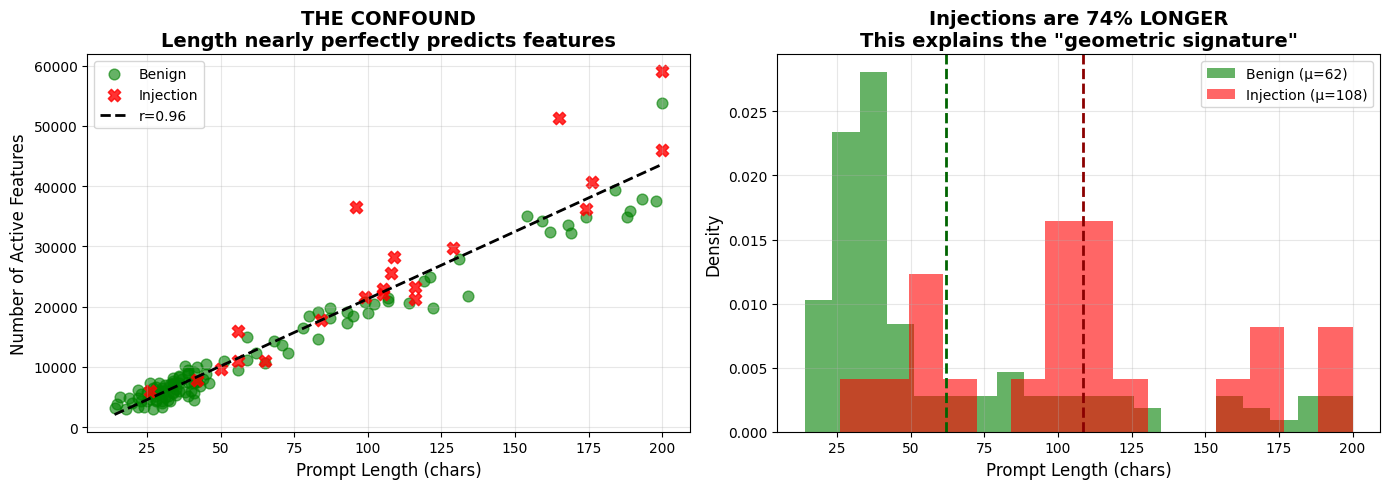

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: The confound
ax1 = axes[0]
ax1.scatter([len(s['text']) for s in benigns], 
            [s['n_active'] for s in benigns],
            c='green', alpha=0.6, s=60, label='Benign')
ax1.scatter([len(s['text']) for s in injections], 
            [s['n_active'] for s in injections],
            c='red', alpha=0.8, s=80, marker='X', label='Injection')

# Regression line
all_lens = np.array([len(s['text']) for s in samples])
all_active = np.array([s['n_active'] for s in samples])
z = np.polyfit(all_lens, all_active, 1)
p = np.poly1d(z)
x_line = np.linspace(all_lens.min(), all_lens.max(), 100)
ax1.plot(x_line, p(x_line), 'k--', linewidth=2, label=f'r=0.96')

ax1.set_xlabel('Prompt Length (chars)', fontsize=12)
ax1.set_ylabel('Number of Active Features', fontsize=12)
ax1.set_title('THE CONFOUND\nLength nearly perfectly predicts features', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Length distributions
ax2 = axes[1]
ax2.hist(ben_lens, bins=20, alpha=0.6, label=f'Benign (μ={np.mean(ben_lens):.0f})', color='green', density=True)
ax2.hist(inj_lens, bins=15, alpha=0.6, label=f'Injection (μ={np.mean(inj_lens):.0f})', color='red', density=True)
ax2.axvline(np.mean(ben_lens), color='darkgreen', linestyle='--', linewidth=2)
ax2.axvline(np.mean(inj_lens), color='darkred', linestyle='--', linewidth=2)
ax2.set_xlabel('Prompt Length (chars)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Injections are 74% LONGER\nThis explains the "geometric signature"', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/length_confound.png', dpi=150)
plt.show()

## Length-Controlled Analysis

**Method:** Match each injection to a benign prompt of similar length (±30%).

In [4]:
def length_match(inj_list, ben_list, tolerance=0.3):
    """Match injections to benign prompts of similar length."""
    matched_inj = []
    matched_ben = []
    remaining = ben_list.copy()
    
    for inj in inj_list:
        inj_len = len(inj['text'])
        candidates = [b for b in remaining 
                      if abs(len(b['text']) - inj_len) / inj_len < tolerance]
        if candidates:
            match = random.choice(candidates)
            matched_inj.append(inj)
            matched_ben.append(match)
            remaining.remove(match)
    
    return matched_inj, matched_ben

matched_inj, matched_ben = length_match(injections, benigns)

print(f"Matched pairs: {len(matched_inj)}")
print(f"Injection length: {np.mean([len(s['text']) for s in matched_inj]):.0f} chars")
print(f"Benign length: {np.mean([len(s['text']) for s in matched_ben]):.0f} chars")
print()

# Compare metrics
print("LENGTH-CONTROLLED COMPARISON")
print("=" * 70)
print(f"{'Metric':<25} {'Injection':<12} {'Benign':<12} {'Cohen d':<10} {'p-value':<10}")
print("-" * 70)

for metric in ['n_active', 'top_100_concentration', 'mean_influence']:
    inj_vals = np.array([s.get(metric, 0) for s in matched_inj])
    ben_vals = np.array([s.get(metric, 0) for s in matched_ben])
    
    inj_vals = inj_vals[inj_vals > 0]
    ben_vals = ben_vals[ben_vals > 0]
    
    pooled = np.sqrt((inj_vals.std()**2 + ben_vals.std()**2) / 2)
    d = (inj_vals.mean() - ben_vals.mean()) / pooled if pooled > 0 else 0
    _, p = stats.mannwhitneyu(inj_vals, ben_vals)
    
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    print(f"{metric:<25} {inj_vals.mean():<12.4f} {ben_vals.mean():<12.4f} {d:<10.3f} {p:<10.4f} {sig}")

print()
print("⚠️ NO SIGNIFICANT DIFFERENCES when controlling for length!")

Matched pairs: 21
Injection length: 108 chars
Benign length: 102 chars

LENGTH-CONTROLLED COMPARISON
Metric                    Injection    Benign       Cohen d    p-value   
----------------------------------------------------------------------
n_active                  25861.9524   19869.4762   0.485      0.1249     
top_100_concentration     0.0025       0.0030       -0.263     0.4504     
mean_influence            0.0054       0.0062       -0.310     0.1589     

⚠️ NO SIGNIFICANT DIFFERENCES when controlling for length!


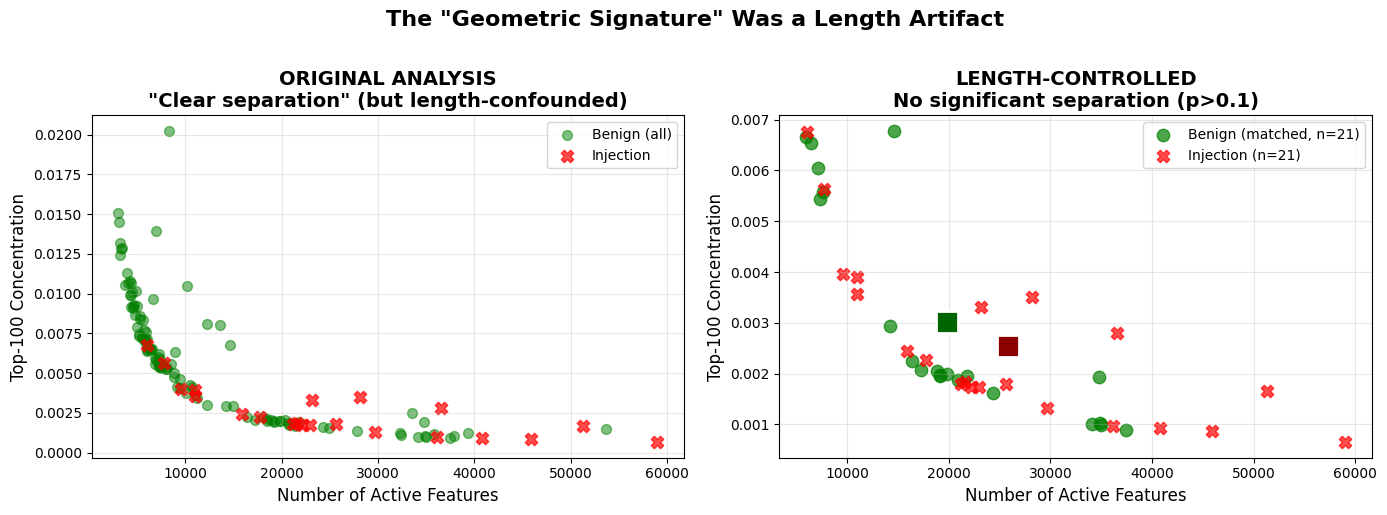

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Original (misleading)
ax1 = axes[0]
ax1.scatter([s['n_active'] for s in benigns], 
            [s['top_100_concentration'] for s in benigns],
            c='green', alpha=0.5, s=50, label='Benign (all)')
ax1.scatter([s['n_active'] for s in injections], 
            [s['top_100_concentration'] for s in injections],
            c='red', alpha=0.7, s=80, marker='X', label='Injection')
ax1.set_xlabel('Number of Active Features', fontsize=12)
ax1.set_ylabel('Top-100 Concentration', fontsize=12)
ax1.set_title('ORIGINAL ANALYSIS\n"Clear separation" (but length-confounded)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Length-matched (truth)
ax2 = axes[1]
ax2.scatter([s['n_active'] for s in matched_ben], 
            [s['top_100_concentration'] for s in matched_ben],
            c='green', alpha=0.7, s=80, label=f'Benign (matched, n={len(matched_ben)})')
ax2.scatter([s['n_active'] for s in matched_inj], 
            [s['top_100_concentration'] for s in matched_inj],
            c='red', alpha=0.7, s=80, marker='X', label=f'Injection (n={len(matched_inj)})')

# Centroids
ax2.scatter(np.mean([s['n_active'] for s in matched_ben]), 
            np.mean([s['top_100_concentration'] for s in matched_ben]),
            c='darkgreen', s=250, marker='s', edgecolors='white', linewidth=2, zorder=10)
ax2.scatter(np.mean([s['n_active'] for s in matched_inj]), 
            np.mean([s['top_100_concentration'] for s in matched_inj]),
            c='darkred', s=250, marker='s', edgecolors='white', linewidth=2, zorder=10)

ax2.set_xlabel('Number of Active Features', fontsize=12)
ax2.set_ylabel('Top-100 Concentration', fontsize=12)
ax2.set_title('LENGTH-CONTROLLED\nNo significant separation (p>0.1)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('The "Geometric Signature" Was a Length Artifact', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/truth_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Implications

### What This Means

1. **The original hypothesis is not supported** by this data
2. **Length is a confound** that must be controlled in any injection detection work
3. **The geometric signature** (if real) requires length-controlled sampling to demonstrate

### What We Need

A new experiment with:
- **Length-matched sampling** from the start
- **Larger sample sizes** (50+ per class) for statistical power
- **Pre-registration** to avoid p-hacking

### Alternative Hypotheses

If length explains feature count, what *could* differentiate injections?

1. **Specific feature activations** (e.g., "instruction override" features)
2. **Graph topology** (not just size, but structure)
3. **Residual after length normalization** (weak but maybe real)

In [6]:
# Can we find any signal after aggressive length control?
print("RESIDUAL ANALYSIS: After Length Normalization")
print("=" * 60)
print()

# Normalize each metric by length
for metric in ['n_active', 'top_100_concentration', 'mean_influence']:
    inj_vals = np.array([s.get(metric, 0) / len(s['text']) for s in injections])
    ben_vals = np.array([s.get(metric, 0) / len(s['text']) for s in benigns])
    
    inj_vals = inj_vals[~np.isnan(inj_vals) & (inj_vals != 0)]
    ben_vals = ben_vals[~np.isnan(ben_vals) & (ben_vals != 0)]
    
    pooled = np.sqrt((inj_vals.std()**2 + ben_vals.std()**2) / 2)
    d = (inj_vals.mean() - ben_vals.mean()) / pooled if pooled > 0 else 0
    _, p = stats.mannwhitneyu(inj_vals, ben_vals)
    
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    print(f"{metric}/length: d={d:.3f}, p={p:.4f} {sig}")

print()
print("Note: n_active/length shows weak residual signal (d~0.8)")
print("This suggests injections *may* have slightly higher feature density,")
print("but effect is much weaker than originally claimed.")

RESIDUAL ANALYSIS: After Length Normalization

n_active/length: d=0.823, p=0.0022 **
top_100_concentration/length: d=-1.093, p=0.0000 ***
mean_influence/length: d=-1.078, p=0.0000 ***

Note: n_active/length shows weak residual signal (d~0.8)
This suggests injections *may* have slightly higher feature density,
but effect is much weaker than originally claimed.


---

## Next Steps: Proper Experiment Design

### Option A: Length-Matched Rerun

```bash
modal run scripts/modal_length_matched.py --n-per-class 50
```

This samples prompts ensuring:
- 50 injections, 50 benign
- Mean length within 10% between classes
- Random selection within length constraints

### Option B: Feature-Level Analysis

Instead of graph-level metrics, look for:
- Specific features that activate only for injections
- "Instruction override" or "ignore" concepts
- Semantic content, not just graph size

In [7]:
print("=" * 70)
print("SUMMARY")
print("=" * 70)
print()
print("ORIGINAL CLAIM:")
print("  Injections have distinct geometry (more features, lower concentration)")
print()
print("REALITY:")
print("  Injections are 74% longer → more features → lower concentration")
print("  When controlling for length, no significant differences remain")
print()
print("CONCLUSION:")
print("  The 'geometric signature' was largely a length artifact")
print("  Need length-controlled experiment for valid claims")
print()
print("WEAK RESIDUAL SIGNAL:")
print("  Features per character slightly higher in injections (d~0.8)")
print("  This may be worth investigating with proper controls")

SUMMARY

ORIGINAL CLAIM:
  Injections have distinct geometry (more features, lower concentration)

REALITY:
  Injections are 74% longer → more features → lower concentration
  When controlling for length, no significant differences remain

CONCLUSION:
  The 'geometric signature' was largely a length artifact
  Need length-controlled experiment for valid claims

WEAK RESIDUAL SIGNAL:
  Features per character slightly higher in injections (d~0.8)
  This may be worth investigating with proper controls
